In [1]:
from utils import parse_annotation, calculate_IoU, Object, Annotation
import collections
import os
import matplotlib.pyplot as plt
import numpy as np
from pyclustering.cluster.kmeans import kmeans as KMeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer, random_center_initializer
import time

In [2]:
path = '.\VOCdevkit\VOC2007\Annotations'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.xml' in file:
            files.append(os.path.join(r, file))
            
#files = files[:500]

annotations = [parse_annotation(file) for file in files]

In [3]:
def average_IoU(true, centers):
    IoU = 0.0
    
    for i in range(len(true)):
        
        
        IoU += calculate_IoU(true[i], pred[i])
        
    return IoU / len(true)    

In [4]:
def distance(boxcoords, centroid):
    if boxcoords.ndim > 1:        
        result = []
        
        for i in range(len(boxcoords)):
            result.append(distance(boxcoords[i], centroid[i]))
            
        return result
    
    box = Object(xmin = 0, xmax = boxcoords[0], ymin = 0, ymax = boxcoords[1])    
    
    centroid_box = Object(xmin = 0, xmax = centroid[0], ymin = 0, ymax = centroid[1])    
    
    return 1 - calculate_IoU(box, centroid_box)

        
def find_anchor_boxes(kmeans_values, n_boxes):    
    initial_centers = kmeans_plusplus_initializer(kmeans_values, n_boxes).initialize()

    metric = distance_metric(type_metric.USER_DEFINED, func=distance)
    
    kmeans = KMeans(n_clusters = n_boxes, data = kmeans_values, initial_centers = initial_centers, metric = metric)
    
    kmeans.process()
    
    centers = kmeans.get_centers()
    clusters = kmeans.get_clusters()
    
    return centers, clusters
    
kmeans_values = []
for annotation in annotations:
    for obj in annotation.objects:
        width = obj.xmax - obj.xmin
        height = obj.ymax - obj.ymin

        kmeans_values.append(np.array([width, height]))
    
#centers, clusters = find_anchor_boxes(kmeans_values, 5)

In [5]:
def get_average_IoU(kmeans_values, centers):
    max_IoUs = []
    
    for obj in kmeans_values:
        IoUs = []
        for center in centers:
            current_IoU = 1 - distance(obj, center)
            IoUs.append(current_IoU)

        max_IoU = max(IoUs)
        max_IoUs.append(max_IoU)

    average_IoU = sum(max_IoUs) / len(max_IoUs)
    
    return average_IoU

In [7]:
start = time.time()
centers, clusters = find_anchor_boxes(kmeans_values, 5)
end = time.time()
print(f'Ran KMeans in {(end - start):.2f}s')

start = time.time()
average_IoU = get_average_IoU(kmeans_values, centers)
end = time.time()
print(f'Calculated average IoU in {(end - start):.2f}s')

print(average_IoU)

Ran KMeans in 32.28s
Calculated average IoU in 1.03s
0.5867718187117289


For 1 clusters: Average IoU: 0.3091856559880461, ran KMeans in: 0.80s
For 2 clusters: Average IoU: 0.4557420031732002, ran KMeans in: 5.11s
For 3 clusters: Average IoU: 0.5281714917623662, ran KMeans in: 11.77s
For 4 clusters: Average IoU: 0.554402191678774, ran KMeans in: 25.25s
For 5 clusters: Average IoU: 0.586824130612268, ran KMeans in: 37.31s
For 6 clusters: Average IoU: 0.6085893821413042, ran KMeans in: 34.12s
For 7 clusters: Average IoU: 0.6278803673681637, ran KMeans in: 90.84s
For 8 clusters: Average IoU: 0.6394608803056571, ran KMeans in: 72.69s
For 9 clusters: Average IoU: 0.6539855603732873, ran KMeans in: 134.48s
For 10 clusters: Average IoU: 0.6698109687555935, ran KMeans in: 111.54s
For 11 clusters: Average IoU: 0.6765487593766614, ran KMeans in: 88.69s
For 12 clusters: Average IoU: 0.6848521314044935, ran KMeans in: 154.15s
For 13 clusters: Average IoU: 0.6946661160212083, ran KMeans in: 113.31s
For 14 clusters: Average IoU: 0.7002390121853992, ran KMeans in: 126.67s


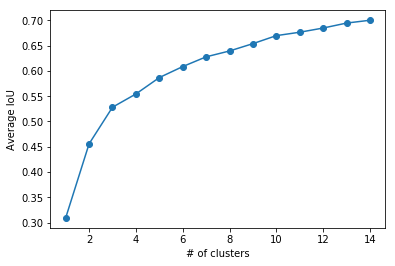

In [8]:
ks = []
anchors = []
IoUs = []
for k in range(1, 15):   
    start = time.time()
    
    ks.append(k)
    
    centers, clusters = find_anchor_boxes(kmeans_values, k)
    anchors.append(centers)
    average_IoU = get_average_IoU(kmeans_values, centers)
    IoUs.append(average_IoU)
    
    end = time.time()
    print(f'For {k} clusters: Average IoU: {average_IoU}, ran KMeans in: {(end - start):.2f}s')
    
plt.plot(ks, IoUs, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('Average IoU')
plt.show()

In [9]:
for anchor in anchors:
    print(anchor)

[[141.51589835270082, 147.8135614864002]]
[[250.6336677485984, 241.50191796990262], [58.265083295812694, 76.33453399369654]]
[[43.76334710111672, 58.45387792565397], [130.80348535409715, 164.52743789395626], [328.2731171267757, 280.2149557759314]]
[[41.00169376693767, 53.47086720867209], [342.5464238116393, 331.91514882274544], [104.9024852569503, 150.35888795282224], [255.59949256977166, 195.1138093512142]]
[[36.47133254250692, 48.33175168050613], [359.5754263226935, 317.0017490161784], [285.4659383033419, 146.18508997429305], [151.50463522773074, 248.49979846835953], [91.01238317757009, 117.20070093457944]]
[[82.29321221296998, 99.10547564976028], [397.62733260153675, 300.64983534577385], [214.75316455696202, 303.073417721519], [116.32538994800693, 208.93587521663778], [263.3303514376997, 137.20255591054314], [32.982820976491865, 44.91749547920434]]
[[32.413258826517655, 39.935483870967744], [107.53224254090472, 207.8310875842156], [395.23641304347825, 330.4205163043478], [341.350364

In [ ]:
'''
anchors = [[0.57273, 0.677385], [1.87446, 2.06253], [3.33843, 5.47434], [7.88282, 3.52778], [9.77052, 9.16828]]
anchors = [np.array(arr) for arr in anchors]    
    
print(anchors)
print(get_average_IoU(annotations, anchors))
'''